In [1]:
import os
from glob import glob
import rasterio as rio
from tqdm import tqdm
import warnings
import numpy as np
from matplotlib import cm
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
from utils import f_15m, ensemble_agb_15m
import shutil
warnings.filterwarnings("ignore", category=rio.errors.NotGeoreferencedWarning)

## Ensembling
* The ensemble of all 15 models using weighted average was used for the final submission

In [2]:
root_dir = os.getcwd()  # Change to the folder where you stored preprocessed training data

Read pre-computed train/validation/test dataset splits from file

In [4]:
df = pd.read_csv(os.path.join(f'{root_dir}/data/train_val_split_96_0.csv'), dtype={"id": str})
X_train, X_val, X_test = (df["id"].loc[df["dataset"] == 0].values,
                          df["id"].loc[df["dataset"] == 1].values,
                          df["id"].loc[df["dataset"] == 2].values)
print(df["dataset"].value_counts())
print("Total Images: ", len(df))

0    8593
2    2773
1      96
Name: dataset, dtype: int64
Total Images:  11462


Read predictions for all 15 models as well as the ground truth agb of the validation set

In [5]:
m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12, m13, m14, m15 = [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
gt = []
rmse_list = []
for uID in tqdm(X_val):
    m1.append(rio.open(f"{root_dir}/dd_inf_models/val_rxh62fu5_2m/{uID}_agbm.tif").read().flatten())
    m2.append(rio.open(f"{root_dir}/dd_inf_models/val_36m55dbu_2m/{uID}_agbm.tif").read().flatten())
    m3.append(rio.open(f"{root_dir}/dd_inf_models/val_16rpp87m_2m/{uID}_agbm.tif").read().flatten())
    m4.append(rio.open(f"{root_dir}/dd_inf_models/val_3cxdn692_2m/{uID}_agbm.tif").read().flatten())
    m5.append(rio.open(f"{root_dir}/dd_inf_models/val_2ez2ckbq_2m/{uID}_agbm.tif").read().flatten())
    m6.append(rio.open(f"{root_dir}/dd_inf_models/val_3bfd03ru_2m/{uID}_agbm.tif").read().flatten())
    m7.append(rio.open(f"{root_dir}/dd_inf_models/val_38t5o4ji_2m/{uID}_agbm.tif").read().flatten())
    m8.append(rio.open(f"{root_dir}/dd_inf_models/val_2gl7l10s_2m/{uID}_agbm.tif").read().flatten())
    m9.append(rio.open(f"{root_dir}/dd_inf_models/val_1n6dphmx_2m/{uID}_agbm.tif").read().flatten())
    m10.append(rio.open(f"{root_dir}/dd_inf_models/val_k882zmf7_2m/{uID}_agbm.tif").read().flatten())
    m11.append(rio.open(f"{root_dir}/dd_inf_models/val_ksnkp86o_2m/{uID}_agbm.tif").read().flatten())
    m12.append(rio.open(f"{root_dir}/dd_inf_models/val_dbdy005j_2m/{uID}_agbm.tif").read().flatten())
    m13.append(rio.open(f"{root_dir}/dd_inf_models/val_ypve39o8_2m/{uID}_agbm.tif").read().flatten())
    m14.append(rio.open(f"{root_dir}/dd_inf_models/val_d9jgazue_2m/{uID}_agbm.tif").read().flatten())
    m15.append(rio.open(f"{root_dir}/dd_inf_models/val_ep0ar9nv_2m/{uID}_agbm.tif").read().flatten())
    gt.append(rio.open(f"{root_dir}/train_agbm/{uID}_agbm.tif").read().flatten())

m1 = np.array(m1).flatten()
m2 = np.array(m2).flatten()
m3 = np.array(m3).flatten()
m4 = np.array(m4).flatten()
m5 = np.array(m5).flatten()
m6 = np.array(m6).flatten()
m7 = np.array(m7).flatten()
m8 = np.array(m8).flatten()
m9 = np.array(m9).flatten()
m10 = np.array(m10).flatten()
m11 = np.array(m11).flatten()
m12 = np.array(m12).flatten()
m13 = np.array(m13).flatten()
m14 = np.array(m14).flatten()
m15 = np.array(m15).flatten()
gt = np.array(gt).flatten()

100%|█████████████████████████████████████████████████| 96/96 [00:04<00:00, 19.93it/s]


Fit a linear model between model predictions and agb of the validation set to extract weights

In [6]:
pred = np.stack((m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12, m13, m14, m15), axis=0)
popt, pcov = curve_fit(f_15m, pred, gt) 
print(f'AGBD = {round(popt[0], 4)} + {round(popt[1], 4)}*m1 + {round(popt[2], 4)}*m2 + {round(popt[3], 4)}*m3 + '
      f'{round(popt[4], 4)}*m4 + {round(popt[5], 4)}*m5 + {round(popt[6], 4)}*m6 + {round(popt[7], 4)}*m7 + '
      f'{round(popt[8], 4)}*m8 + {round(popt[9], 4)}*m9 + {round(popt[10], 4)}*m10 + {round(popt[11], 4)}*m11 + '
      f'{round(popt[12], 4)}*m12 + {round(popt[13], 4)}*m13 + {round(popt[14], 4)}*m14 + {round(popt[15], 4)}*m15')
pred = popt[0] + popt[1] * pred[0] + popt[2] * pred[1] + popt[3] * pred[2] +  popt[4] * pred[3] + popt[5] * pred[4] + \
       popt[6] * pred[5] + popt[7] * pred[6] + popt[8] * pred[7] + popt[9] * pred[8] + popt[10] * pred[9] + \
       popt[11] * pred[10] + popt[12] * pred[11] + popt[13] * pred[12] + popt[14] * pred[13] + popt[15] * pred[14]

AGBD = -1.3134 + 0.0928*m1 + 0.0098*m2 + 0.0391*m3 + 0.0716*m4 + -0.1241*m5 + -0.0849*m6 + -0.0913*m7 + 0.093*m8 + 0.103*m9 + 0.2246*m10 + 0.2344*m11 + 0.1126*m12 + 0.1623*m13 + 0.0571*m14 + 0.1378*m15


Here I replace all negative predictions to 0, which also slightly improved model performance

In [7]:
pred[pred < 0] = 0

Here I plot final ensemble predictions against the agb of the validation set. Note: final ensemble RMSE of 30.22 below is higher than that of the submission simply because it was calculated across all of the validation data, as opposed to an average RMSE per image, which was 27.81


 Accuracy metrics: 

R2 : 0.83
RMSE (Mg/ha): 30.209999084472656
RMSE% (Mg/ha): 47.1%


/tmp/ipykernel_821494/1370930713.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  hb = ax.hexbin(gt, pred, gridsize=(500, 500),  bins='log', cmap=cm.get_cmap('jet'),  # jet or turbo?


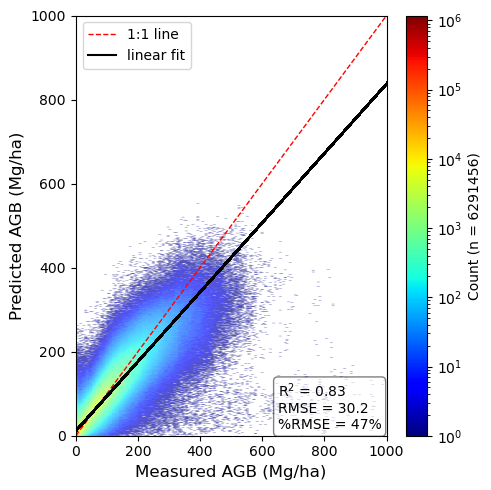

In [8]:
print("\n Accuracy metrics: \n")
reg = LinearRegression().fit(gt.reshape(-1, 1), pred.reshape(-1, 1))
r2_score_reg = round(reg.score(gt.reshape(-1, 1), pred.reshape(-1, 1)), 2)
print(f"R2 : {r2_score_reg}")
rmse_score = round(np.sqrt(mean_squared_error(gt, pred)), 2)
print(f"RMSE (Mg/ha): {rmse_score}")
rmse_percent = round(rmse_score / np.mean(gt) * 100, 1)
print(f"RMSE% (Mg/ha): {rmse_percent}%")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

hb = ax.hexbin(gt, pred, gridsize=(500, 500),  bins='log', cmap=cm.get_cmap('jet'),  # jet or turbo?
               mincnt=1, edgecolors='none', linewidths=0.2)  # (100, 35)
cb = fig.colorbar(hb, ax=ax, label=f'Count (n = {len(gt)})')

ax.plot((0, 1000), (0, 1000), 'r--', linewidth=1, label='1:1 line')
ax.plot(gt.reshape(-1, 1), reg.predict(gt.reshape(-1, 1)), color='black',
        label='linear fit')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.xlabel(f'Measured AGB (Mg/ha)', fontsize=12)
plt.ylabel(f'Predicted AGB (Mg/ha)', fontsize=12)
plt.legend(loc="upper left")
textstr = '\n'.join((
    r"$\mathregular{R^2}$ = " + str(round(r2_score_reg, 2)),
    r"RMSE = " + str(round(rmse_score, 1)),
    f"%RMSE = {int(round(rmse_percent, 1))}%"
))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.65, 0.13, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()

Here we apply weighted average with fitted parameters to the test set

In [10]:
ensemble_agb_15m(uIDs=X_test, popt=popt,
                 m1_path=f"{root_dir}/dd_inf_models/test_rxh62fu5_2m",
                 m2_path=f"{root_dir}/dd_inf_models/test_36m55dbu_2m",
                 m3_path=f"{root_dir}/dd_inf_models/test_16rpp87m_2m",
                 m4_path=f"{root_dir}/dd_inf_models/test_3cxdn692_2m",
                 m5_path=f"{root_dir}/dd_inf_models/test_2ez2ckbq_2m",
                 m6_path=f"{root_dir}/dd_inf_models/test_3bfd03ru_2m",
                 m7_path=f"{root_dir}/dd_inf_models/test_38t5o4ji_2m",
                 m8_path=f"{root_dir}/dd_inf_models/test_2gl7l10s_2m",
                 m9_path=f"{root_dir}/dd_inf_models/test_1n6dphmx_2m",
                 m10_path=f"{root_dir}/dd_inf_models/test_k882zmf7_2m",
                 m11_path=f"{root_dir}/dd_inf_models/test_ksnkp86o_2m",
                 m12_path=f"{root_dir}/dd_inf_models/test_dbdy005j_2m",
                 m13_path=f"{root_dir}/dd_inf_models/test_ypve39o8_2m",
                 m14_path=f"{root_dir}/dd_inf_models/test_d9jgazue_2m",
                 m15_path=f"{root_dir}/dd_inf_models/test_ep0ar9nv_2m",
                 output_path_dir=f"{root_dir}/submission_15m")

100%|█████████████████████████████████████████████| 2773/2773 [02:48<00:00, 16.50it/s]


And zipping for the final submission

In [11]:
shutil.make_archive(base_name=f"{root_dir}/submission_15m", format="zip", root_dir=f"{root_dir}/submission_15m")

'/home/ubuntu/the-biomassters/3rd-place/submission_15m.zip'